# COURSE: PCA and multivariate neural signal processing
## SECTION: Source separation with GED
### VIDEO: Python: Effects of regularization in real data
#### Instructor: sincxpress.com

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy
import scipy.io as sio
from pytopo import topoplotIndie
from filterFGxfun import filterFGx

In [3]:
# import the data

matfile = sio.loadmat('MATLAB_data_files//sampleEEGdata.mat')
EEG = matfile['EEG'][0,0]
EEG['times'] = EEG['times'][0]
EEG['data'] = np.double(EEG['data'])

In [19]:
# regularization amount
regu_gam = 0.01

# filter data in alpha
centerFreq = 11
freqFWHM = 4

fdata = copy.deepcopy(EEG['data'])
for ti in range(int(EEG['trials'])):
    tmdat = EEG['data'][:,:,ti]
    fdata[:,:,ti] = filterFGx(tmdat,EEG['srate'][0][0],centerFreq,freqFWHM)[0]

In [20]:
## GED on broadband vs. narrowband covariances

# covariance matrices
covB = np.zeros( (EEG['nbchan'][0][0],EEG['nbchan'][0][0]) )
covF = np.zeros( (EEG['nbchan'][0][0],EEG['nbchan'][0][0]) )

for ti in range(EEG['trials'][0][0]):
    
    # covariance of broadband
    covB += np.cov(EEG['data'][:,:,ti])
    
    # covariance of post-stim period
    covF += np.cov(fdata[:,:,ti])
    
# average covariances by dividing by trials
covB = covB/ti
covF = covF/ti



###### regularization #####
Rregu = (1-regu_gam)*covB + regu_gam*np.mean(np.linalg.eig(covB)[0])*np.eye(EEG['nbchan'][0][0])



### GED
evals,evecs = scipy.linalg.eigh(covF,Rregu)
# sort according to eigenvalues
soidx = np.argsort(evals)[::-1]
evals = evals[soidx]
evecs = evecs[:,soidx]

# component time series
tmpts = evecs[:,0].T @ np.reshape(EEG['data'],(EEG['nbchan'][0][0],-1),order='F')
ts = np.reshape( tmpts,(EEG['pnts'][0][0],EEG['trials'][0][0]),order='F' )
             
# topomaps and time series
topo = evecs[:,0].T@covF
mv = np.argmax(np.abs(topo))
if topo[mv]<0:
    topo = -topo
    ts = -ts

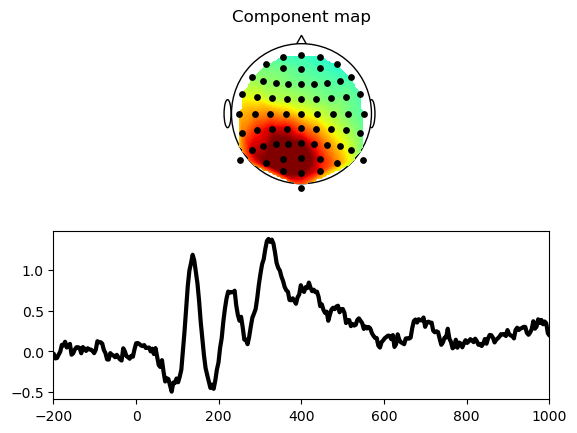

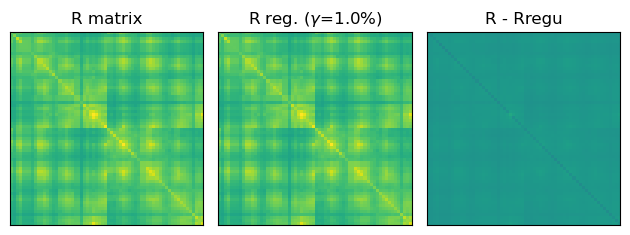

In [21]:
## some plotting

_,axs = plt.subplots(2,1)
# topoplot of component map
topoplotIndie(topo,EEG['chanlocs'],'Component map',axs[0])


# ERP
axs[1].plot(EEG['times'],np.mean(ts,axis=1),'k',linewidth=3)
axs[1].set_xlim([-200, 1000])
plt.show()


#### show both covariance matrices
_,axs = plt.subplots(1,3)

axs[0].imshow(covB,vmin=-150,vmax=150)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('R matrix')

axs[1].imshow(Rregu,vmin=-150,vmax=150)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title(f'R reg. ($\gamma$={100*regu_gam}%)')


axs[2].imshow(covB-Rregu,vmin=-10,vmax=10)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title('R - Rregu')


plt.tight_layout()
plt.show()